In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette(sns.color_palette("tab10", 8))
%config Completer.use_jedi = False

In [16]:
def simulate_dice_throws(dice_n_faces=6, max_n_simultaneous_throws=6, n_simulations = 1000000):
    simulated_throws = np.random.randint(low = 1, high = dice_n_faces+1, 
                                         size=(n_simulations,max_n_simultaneous_throws))
    throws = pd.DataFrame(simulated_throws)

    return throws

def prob_at_least_1_higher_than(throws, dice_n_faces=6, max_n_simultaneous_throws=6):
    n_simulations = len(throws)
    my_probs ={}
    final_results = pd.DataFrame()
    aggregated_results = []
    empty_col = np.full((n_simulations, 1), False)

    for i_n_simultaneous_throws in np.arange(1,max_n_simultaneous_throws+1):
        for i_threshold in np.arange(1,dice_n_faces+1):
            temp_results = {}

            tt = throws >= i_threshold
            tt['results'] = empty_col

            for i_throw_n in np.arange(0, i_n_simultaneous_throws): 
                tt['results'] = tt[i_throw_n] | tt['results']

            my_prob = sum(tt['results'])/len(tt['results'])

            temp_results['dice_n'] = i_n_simultaneous_throws
            temp_results['i_threshold'] = i_threshold
            temp_results['prob'] = my_prob

            aggregated_results.append(temp_results)
            
    results_df = pd.DataFrame(aggregated_results)        
    return results_df

Text(0.5, 1.0, 'P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d4)')

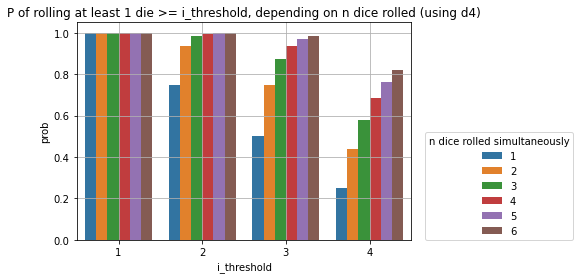

In [17]:
dice_n_faces=4
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws)

ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0), title="n dice rolled simultaneously")
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')

Text(0.5, 1.0, 'P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d6)')

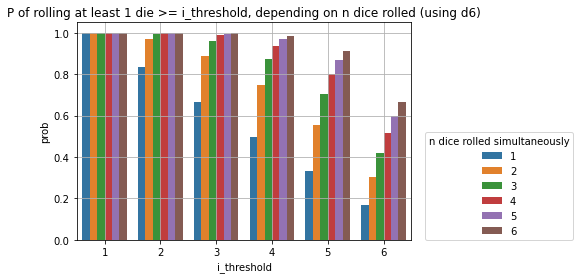

In [18]:
dice_n_faces=6
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws)

ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0), title="n dice rolled simultaneously")
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')

Text(0.5, 1.0, 'P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d8)')

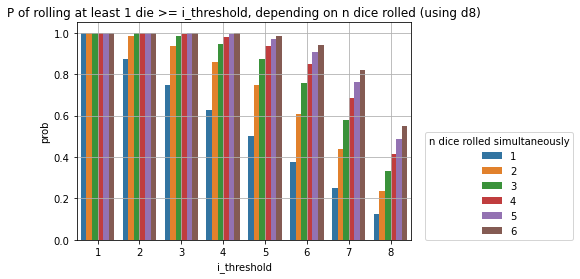

In [19]:
dice_n_faces=8
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws)


ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0), title="n dice rolled simultaneously")
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')

Text(0.5, 1.0, 'P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d10)')

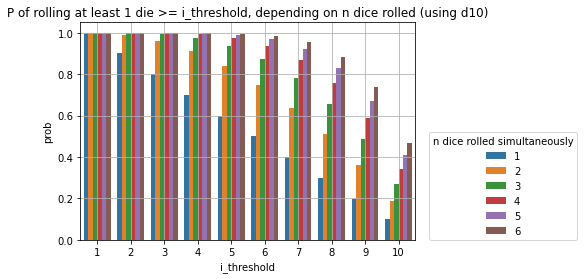

In [20]:
dice_n_faces=10
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws)

ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0), title="n dice rolled simultaneously")
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')

Text(0.5, 1.0, 'P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d12)')

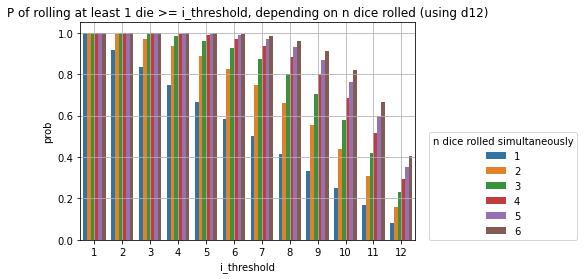

In [21]:
dice_n_faces=12
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws)

ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0), title="n dice rolled simultaneously")
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')